<a href="https://colab.research.google.com/github/JohnKurian/EnFVe/blob/master/fever_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!pip install --upgrade allennlp
!pip install allennlp-models==1.0.0
!pip install --upgrade spacy

     |████████████████████████████████| 501kB 9.8MB/s 
     |████████████████████████████████| 266kB 29.5MB/s 
     |████████████████████████████████| 1.3MB 31.7MB/s 
     |████████████████████████████████| 317kB 58.7MB/s 
     |████████████████████████████████| 133kB 51.2MB/s 
     |████████████████████████████████| 1.1MB 48.5MB/s 
     |████████████████████████████████| 2.9MB 53.9MB/s 
     |████████████████████████████████| 890kB 51.6MB/s 
     |████████████████████████████████| 71kB 9.9MB/s 
     |████████████████████████████████| 6.7MB 52.0MB/s 
  Created wheel for jsonnet: filename=jsonnet-0.16.0-cp36-cp36m-linux_x86_64.whl size=3321576 sha256=4abeb149e3370379fde07bca50fc9c712fe8ec159c0e7b08b3c53b9bb68c9007
  Stored in directory: /root/.cache/pip/wheels/64/a9/43/bc5e0463deeec89dfca928a2a64595f1bdb520c891f6fbd09c
  Created wheel for overrides: filename=overrides-3.1.0-cp36-none-any.whl size=10174 sha256=50d7f44b5a9417b3164a6f41de4c6479727658fd919dadbd58e82e448e0c94a6
  Stored in d

In [3]:
!git clone https://github.com/facebookresearch/DrQA.git
%cd DrQA
!pip install -r requirements.txt
!python setup.py develop

Cloning into 'DrQA'...
remote: Enumerating objects: 265, done.
remote: Total 265 (delta 0), reused 0 (delta 0), pack-reused 265
Receiving objects: 100% (265/265), 562.37 KiB | 21.63 MiB/s, done.
Resolving deltas: 100% (127/127), done.
/content/DrQA
     |████████████████████████████████| 225kB 9.8MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
  Found existing installation: pexpect 4.8.0
    Uninstalling pexpect-4.8.0:
      Successfully uninstalled pexpect-4.8.0


running develop
running egg_info
creating drqa.egg-info
writing drqa.egg-info/PKG-INFO
writing dependency_links to drqa.egg-info/dependency_links.txt
writing requirements to drqa.egg-info/requires.txt
writing top-level names to drqa.egg-info/top_level.txt
writing manifest file 'drqa.egg-info/SOURCES.txt'
writing manifest file 'drqa.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.6/dist-packages/drqa.egg-link (link to .)
Adding drqa 0.1.0 to easy-install.pth file

Installed /content/DrQA
Processing dependencies for drqa==0.1.0
Searching for pexpect==4.2.1
Best match: pexpect 4.2.1
Adding pexpect 4.2.1 to easy-install.pth file

Using /usr/local/lib/python3.6/dist-packages
Searching for elasticsearch==7.9.1
Best match: elasticsearch 7.9.1
Adding elasticsearch 7.9.1 to easy-install.pth file

Using /usr/local/lib/python3.6/dist-packages
Searching for nltk==3.2.5
Best match: nltk 3.2.5
Adding nltk 3.2.5 to easy-install.pth file

Using /usr/local/lib/python3.6/dist-pac

In [4]:
import argparse
import json
import os
import re
import nltk
import pandas as pd
import difflib
from nltk.tokenize import sent_tokenize 
from allennlp.predictors.predictor import Predictor
import allennlp_models.structured_prediction
from drqa.retriever.utils import normalize
from nltk import Tree
from tqdm import tqdm
tqdm.pandas()
import numpy as np
import spacy
import time
from spacy.lang.en import English
nltk.download('punkt')
nlp = English()
nlp = spacy.load('en_core_web_sm')
sbd = nlp.create_pipe('sentencizer')
nlp.add_pipe(sbd)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.6/dist-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [5]:
def get_tree_depth(df):
    df = df.copy()
    evidences = df.loc['evd_1':'evd_5'].values
    max_depth = []
    for evid in evidences:
      if isinstance(evid, str):
        p = predictor.predict(evid)
        try:
          tree = Tree.fromstring(p['trees'])
        except ValueError:
          print(f"skipped")
        n_leaves = len(tree.leaves())
        leavepos = set(tree.leaf_treeposition(n) for n in range(n_leaves))
        leaves_depth = []
        for pos in tree.treepositions():
          if pos in leavepos:
            leaves_depth.append(len(pos))
        max_depth.append(np.max(leaves_depth))
    return max_depth[0]

def get_length(df):
  df = df.copy()
  evidences = df.loc['evd_1':'evd_5'].values
  length = []
  for evid in evidences:
    if isinstance(evid, str):
      evid = evid.strip()
      evid = ' '.join(evid.split())
      length.append(len(evid))
  return round(np.mean(length),2)

def get_pronoun(df):
  df = df.copy()
  evidences = df.loc['evd_1':'evd_5'].values
  avg_length = []
  for evid in evidences:
    if isinstance(evid, str):
      sent_doc = nlp(evid)
      pronouns = []
      for token in sent_doc:
        if token.pos_ == 'PRON':
          pronouns.append(str(token))
      pron_len = len(pronouns)
      avg_length.append(pron_len)
  return np.max(avg_length)

In [6]:
tsv_file='/content/gear-dev-set-0_001.tsv'
df=pd.read_table(tsv_file, sep='\t')
df.to_csv('gear_dev.csv', index=True)
df.columns = ['id', 'label', 'claim', 'evd_1', 'evd_2', 'evd_3', 'evd_4', 'evd_5']

In [7]:
df_test = df.sample(frac=0.25)

In [8]:
len(df_test)

4987

In [9]:
df_test.head()

,id,label,claim,evd_1,evd_2,evd_3,evd_4,evd_5
11098,11121,NOTENOUGHINFO,One Flew Over the Cuckoo's Nest won the five m...,Considered to be one of the greatest films eve...,The film was the second to win all five major ...,The film version One Flew Over the Cuckoo 's N...,One Flew Over the Cuckoo 's Nest is a 1975 Ame...,One Flew Over the Cuckoo 's Nest -LRB- 1962 -R...
5293,5297,NOTENOUGHINFO,Minorities make up 23 percent of the Universit...,About 55 percent of its undergraduates and 60 ...,"Across all its campuses , it comprises approxi...",It is the state of Mississippi 's flagship and...,NaN,NaN
8641,8653,SUPPORTS,Kleshas are part of Buddhism.,"Kleshas -LRB- -LSB- क्लेश , kleśa -RSB- किलेस ...",In the contemporary Mahayana and Theravada Bud...,Buddhism -LRB- -LSB- pronˈbʊdɪzəm -RSB- or -LS...,"Mahayana , which includes the traditions of Pu...",Practices of Buddhism include taking refuge in...
6216,6222,NOTENOUGHINFO,Kuching is the capital of Kelantan.,"Kuching -LSB- ˈkuːtʃɪŋ -RSB- -LRB- Jawi : , -R...",It is also the capital of Kuching Division . K...,Kuching was the third capital of Sarawak in 18...,"In 1841 , Kuching became the capital of Sarawa...",The capital and royal seat is Kota Bharu . Kot...
10223,10240,REFUTES,Castlevania was developed for the Nintendo Wii.,"Castlevania , also known in Japanese as , is a...",Although the MSX 2 port -LRB- localized in Eur...,"Along with Super Metroid , it popularized the ...",In 2010 saw the release of Castlevania : Lords...,The Metroidvania style game was continued in s...


In [10]:
predictor = Predictor.from_path("https://storage.googleapis.com/allennlp-public-models/elmo-constituency-parser-2020.02.10.tar.gz")

100%|██████████| 374434792/374434792 [00:13<00:00, 28010866.48B/s]
/usr/local/lib/python3.6/dist-packages/spacy/util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.5) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.2). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [ ]:
start = time.time()
df_test['avg_length'] = df_test.progress_apply(get_length, axis=1)
print("Average length calculated")

df_test['max_depth'] = df_test.progress_apply(get_tree_depth, axis=1)
print("Max depth calculated")

df_test['pron_length'] = df_test.progress_apply(get_pronoun, axis=1)
print("Pronoun length calculated")

print(f"Time- {round((time.time()-start)/60, 2)} mins")
df_test.to_csv("/content/drive/My Drive/fever_stats.csv")
print("Saved!")

In [13]:
df_test.head()

,id,label,claim,evd_1,evd_2,evd_3,evd_4,evd_5,avg_length,max_depth,pron_length
11098,11121,NOTENOUGHINFO,One Flew Over the Cuckoo's Nest won the five m...,Considered to be one of the greatest films eve...,The film was the second to win all five major ...,The film version One Flew Over the Cuckoo 's N...,One Flew Over the Cuckoo 's Nest is a 1975 Ame...,One Flew Over the Cuckoo 's Nest -LRB- 1962 -R...,286.80,12,3
5293,5297,NOTENOUGHINFO,Minorities make up 23 percent of the Universit...,About 55 percent of its undergraduates and 60 ...,"Across all its campuses , it comprises approxi...",It is the state of Mississippi 's flagship and...,NaN,NaN,165.33,7,1
8641,8653,SUPPORTS,Kleshas are part of Buddhism.,"Kleshas -LRB- -LSB- क्लेश , kleśa -RSB- किलेस ...",In the contemporary Mahayana and Theravada Bud...,Buddhism -LRB- -LSB- pronˈbʊdɪzəm -RSB- or -LS...,"Mahayana , which includes the traditions of Pu...",Practices of Buddhism include taking refuge in...,395.60,9,0
6216,6222,NOTENOUGHINFO,Kuching is the capital of Kelantan.,"Kuching -LSB- ˈkuːtʃɪŋ -RSB- -LRB- Jawi : , -R...",It is also the capital of Kuching Division . K...,Kuching was the third capital of Sarawak in 18...,"In 1841 , Kuching became the capital of Sarawa...",The capital and royal seat is Kota Bharu . Kot...,177.80,7,1
10223,10240,REFUTES,Castlevania was developed for the Nintendo Wii.,"Castlevania , also known in Japanese as , is a...",Although the MSX 2 port -LRB- localized in Eur...,"Along with Super Metroid , it popularized the ...",In 2010 saw the release of Castlevania : Lords...,The Metroidvania style game was continued in s...,313.00,12,1


In [49]:
print("Constituency Tree Statistics\n")
print(df_test['max_depth'].describe());print("\n")
print("Pronouns Statistics\n")
print(df_test['pron_length'].describe())

Constituency Tree Statistics

count    4987.000000
mean        9.085623
std         3.170905
min         3.000000
25%         7.000000
50%         9.000000
75%        11.000000
max        26.000000
Name: max_depth, dtype: float64


Pronouns Statistics

count    4987.000000
mean        1.128935
std         1.639862
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max        30.000000
Name: pron_length, dtype: float64


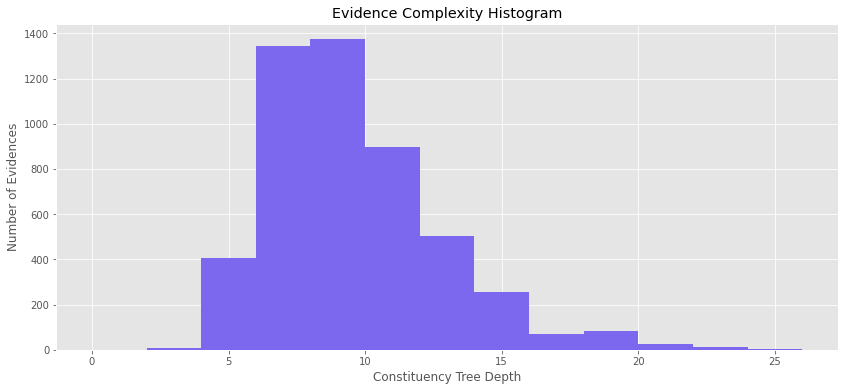

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.figure(figsize=(14,6))
plt.hist(df_test['max_depth'], bins=[0,2,4,6,8,10,12,14,16,18,20,22,24,26], color="mediumslateblue")
plt.xlabel("Constituency Tree Depth")
plt.ylabel("Number of Evidences")
plt.title("Evidence Complexity Histogram")
plt.show()

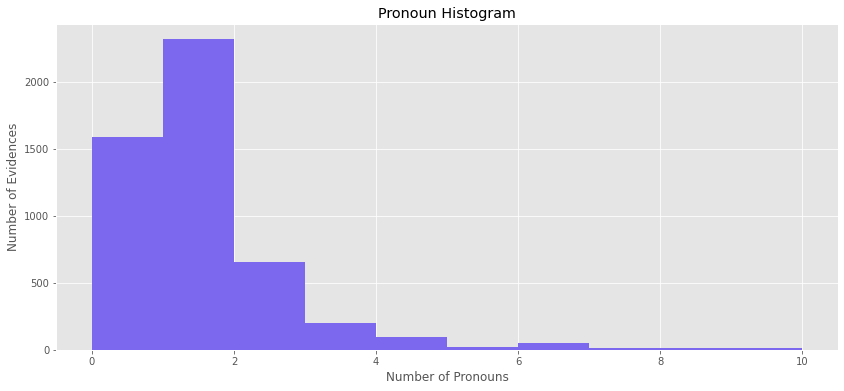

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(14,6))
plt.hist(df_test['pron_length'], bins=[0,1,2,3,4,5,6,7,8,9,10], color="mediumslateblue")
plt.xlabel("Number of Pronouns")
plt.ylabel("Number of Evidences")
plt.title("Pronoun Histogram")
plt.show()